In [ ]:
# Install required libraries
!pip install fluidsynth
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install pyfluidsynth pretty_midi
!pip install pydub music21 librosa numpy scipy yt-dlp
!apt-get install -y musescore3 fluidsynth timidity

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
E: Package 'libfluidsynth1' has no installation candidate
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
musescore3 is already the newest version (3.2.3+dfsg2-11).
timidity is already the newest version (2.14.0-8ubuntu1.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 57 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Import necessary libraries
from pydub import AudioSegment
from music21 import converter, note, stream, chord, environment, tempo
from yt_dlp import YoutubeDL
import librosa
import pretty_midi
import numpy as np
from scipy.io import wavfile
from google.colab import files
from tabulate import tabulate
from tensorflow.keras.models import load_model
from IPython.display import Audio, display, HTML  # Ensure HTML is imported
import pickle
import os

# Set up MuseScore path for music21
env = environment.Environment()
env['musescoreDirectPNGPath'] = '/usr/bin/mscore3'

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load models and metadata
happy_model_path = "/content/drive/MyDrive/emopia_project/happy_model.keras"
sad_model_path = "/content/drive/MyDrive/emopia_project/sad_model.keras"
happy_metadata_path = "/content/drive/MyDrive/emopia_project/happy_metadata.pkl"
sad_metadata_path = "/content/drive/MyDrive/emopia_project/sad_metadata.pkl"

happy_model = load_model(happy_model_path)
sad_model = load_model(sad_model_path)

# Load separate metadata
with open(happy_metadata_path, "rb") as f:
    happy_metadata = pickle.load(f)

with open(sad_metadata_path, "rb") as f:
    sad_metadata = pickle.load(f)

Mounted at /content/drive


🎵 Welcome to the Music Emotion Generator! 🎵
Do you want to upload an MP3 file or provide a YouTube URL? (Enter 'mp3' or 'url'): url
🌐 Please enter the YouTube URL: https://youtu.be/ECX5zpNTdn0?si=rJCRqbv_LdQrJaRb
📥 Downloading audio from YouTube...
[youtube] Extracting URL: https://youtu.be/ECX5zpNTdn0?si=rJCRqbv_LdQrJaRb
[youtube] ECX5zpNTdn0: Downloading webpage
[youtube] ECX5zpNTdn0: Downloading tv player API JSON
[youtube] ECX5zpNTdn0: Downloading ios player API JSON
[youtube] ECX5zpNTdn0: Downloading player 37364e28
[youtube] ECX5zpNTdn0: Downloading m3u8 information
[info] ECX5zpNTdn0: Downloading 1 format(s): 251
[download] Destination: youtube_audio.webm
[download] 100% of    1.01MiB in 00:00:00 at 4.49MiB/s   
[ExtractAudio] Destination: youtube_audio.mp3
Deleting original file youtube_audio.webm (pass -k to keep)
🔧 Processing music...
✅ WAV file is valid. Sample rate: 48000 Hz, Duration: 61.42 seconds

🎶 Extracted Notes:
+-------+----------------------+--------------------+--

📥 Download link for the musical sheet:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🎼 Displaying the musical sheet...


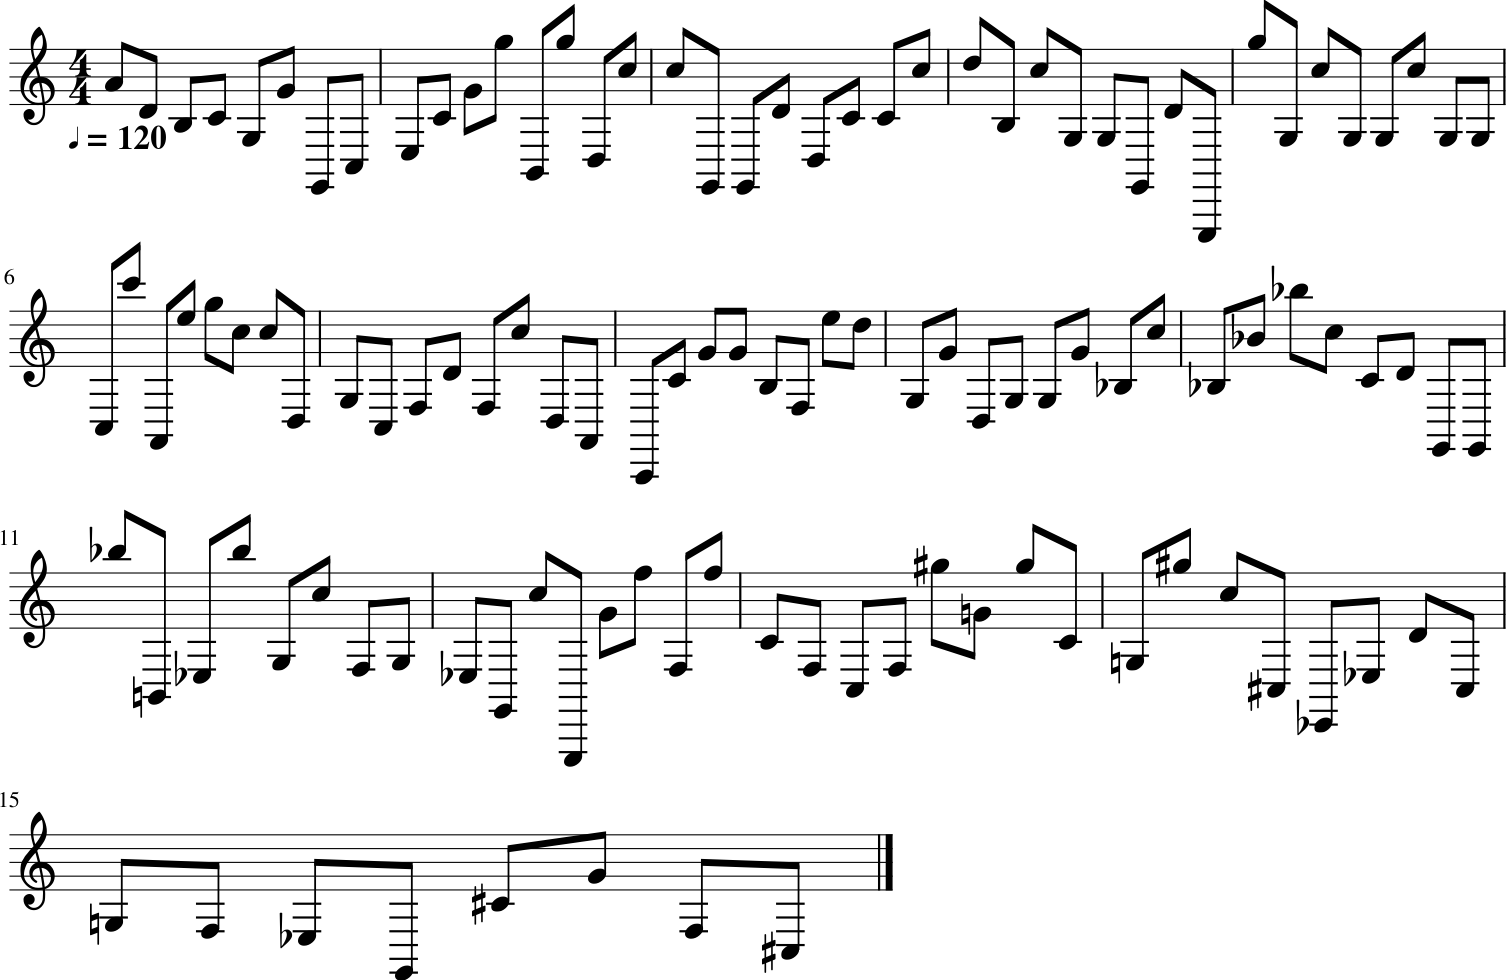

In [ ]:
# Extract unique notes and mappings for each model
happy_unique_notes = happy_metadata['unique_notes']
happy_note_to_int = happy_metadata['note_to_int']
happy_int_to_note = {i: note for note, i in happy_note_to_int.items()}

sad_unique_notes = sad_metadata['unique_notes']
sad_note_to_int = sad_metadata['note_to_int']
sad_int_to_note = {i: note for note, i in sad_note_to_int.items()}

# Function to download audio from YouTube URL and save as MP3
def download_youtube_audio(url, output_file="youtube_audio.mp3"):
    ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': output_file.replace(".mp3", ".%(ext)s"),
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'mp3',
            'preferredquality': '192',
        }],
    }
    with YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    return output_file

# Function to convert MP3 to WAV
def mp3_to_wav(mp3_file):
    sound = AudioSegment.from_mp3(mp3_file)
    wav_file = mp3_file.replace(".mp3", ".wav")
    sound.export(wav_file, format="wav")
    return wav_file

# Function to verify and fix the WAV file
def verify_and_fix_wav(wav_file):
    try:
        rate, data = wavfile.read(wav_file)
        print(f"✅ WAV file is valid. Sample rate: {rate} Hz, Duration: {len(data)/rate:.2f} seconds")
        return True
    except Exception as e:
        print(f"❌ Error loading WAV file: {e}")
        return False

# Function to convert WAV to MIDI using pretty_midi
def wav_to_midi(wav_file):
    midi_file = wav_file.replace(".wav", ".mid")
    y, sr = librosa.load(wav_file, sr=None)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr, units='time')
    if isinstance(tempo, (list, np.ndarray)):
        tempo = tempo[0]
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr, units='time', backtrack=True)
    y_harmonic, _ = librosa.effects.hpss(y)
    pitches, magnitudes = librosa.core.piptrack(y=y_harmonic, sr=sr)
    midi_data = pretty_midi.PrettyMIDI()
    midi_data.tempo = tempo
    instrument = pretty_midi.Instrument(program=0)
    for i, onset in enumerate(onset_frames):
        frame = librosa.time_to_frames(onset, sr=sr)
        pitch_indices = np.where(magnitudes[:, frame] > 0.1 * magnitudes[:, frame].max())[0]
        for pitch_idx in pitch_indices:
            pitch_freq = pitches[pitch_idx, frame]
            if pitch_freq > 0:
                midi_note = librosa.hz_to_midi(pitch_freq)
                if i < len(onset_frames) - 1:
                    duration = onset_frames[i + 1] - onset
                else:
                    duration = 0.5
                velocity = int(np.clip(magnitudes[pitch_idx, frame] / magnitudes[:, frame].max() * 127, 40, 127))
                note = pretty_midi.Note(velocity=velocity, pitch=int(midi_note), start=onset, end=onset + duration)
                instrument.notes.append(note)
    midi_data.instruments.append(instrument)
    midi_data.write(midi_file)
    return midi_file, tempo

# Function to allow user to upload an MP3 file
def upload_mp3_file():
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"📂 Uploaded file: {filename}")
        return filename
    return None

# Function to analyze the MIDI file and extract unique notes
def analyze_midi(midi_file, tempo):
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    notes = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            notes.append({
                "pitch": pretty_midi.note_number_to_name(note.pitch),
                "start": note.start,
                "end": note.end,
                "velocity": note.velocity
            })
    unique_notes = set(note["pitch"] for note in notes)
    print("\n🎶 Extracted Notes:")
    print(tabulate(notes, headers="keys", tablefmt="pretty"))
    print("\n🎼 Summary of Unique Notes:")
    print(tabulate([list(unique_notes)], tablefmt="pretty"))
    print(f"\n🎵 Detected tempo: {tempo:.2f} BPM")
    return list(unique_notes), notes

# Function to generate music with emotion-specific enhancements
def generate_music(model, sequence_length, unique_notes, duration_seconds, emotion, int_to_note, temperature=1.0):
    seed_sequence = np.random.randint(0, len(unique_notes), size=(sequence_length, 1))
    seed_sequence = seed_sequence / float(len(unique_notes))
    generated_notes = []
    current_sequence = seed_sequence

    # Set tempo and note duration based on emotion
    if emotion == "Happy":
        tempo = 120  # Tempo in BPM
        note_duration = 60 / tempo  # Duration of each note in seconds (quarter note)
    else:
        tempo = 70  # Tempo in BPM
        note_duration = 1  # Longer note duration for sad music (legato effect)

    # Calculate the number of notes needed for the desired duration
    target_notes = int((duration_seconds * tempo) / 60)  # Adjusted for tempo

    # Generate notes
    while len(generated_notes) < target_notes:
        current_sequence = np.reshape(current_sequence, (1, sequence_length, 1))
        predicted_probs = model.predict(current_sequence, verbose=0)[0]
        predicted_note_int = sample_with_temperature(predicted_probs, temperature)
        generated_notes.append(predicted_note_int)
        current_sequence = np.append(current_sequence[0, 1:], [[predicted_note_int]], axis=0)

    # Map generated note integers to note names
    generated_notes_names = [int_to_note[note_int] for note_int in generated_notes]
    return generated_notes_names, note_duration

# Function for temperature sampling
def sample_with_temperature(predicted_probs, temperature):
    predicted_probs = np.log(predicted_probs + 1e-10) / temperature
    predicted_probs = np.exp(predicted_probs) / np.sum(np.exp(predicted_probs))
    return np.random.choice(len(predicted_probs), p=predicted_probs)

# Function to display and download the musical sheet
def display_and_download_sheet(music_stream, emotion):
    # Save the sheet music as a PDF
    sheet_path = f"/content/generated_{emotion}_sheet.pdf"
    music_stream.write('musicxml.pdf', fp=sheet_path)

    # Provide a download link
    print("📥 Download link for the musical sheet:")
    from google.colab import files
    files.download(sheet_path)  # Directly download the file

    # Display the sheet music
    print("🎼 Displaying the musical sheet...")
    music_stream.show()

# Function to create a MIDI file from generated notes
def create_midi_file(notes, output_path, emotion, note_duration):
    output_stream = stream.Stream()

    # Set the tempo using a MetronomeMark object
    if emotion == "Happy":
        mm = tempo.MetronomeMark(number=120)  # 120 BPM for happy music
    else:
        mm = tempo.MetronomeMark(number=70)   # 70 BPM for sad music
    output_stream.append(mm)  # Add the tempo to the stream

    for i, n in enumerate(notes):
        if n == "rest":
            new_note = note.Rest()
        elif isinstance(n, chord.Chord):
            output_stream.append(n)
        else:
            new_note = note.Note(n)
            new_note.quarterLength = note_duration  # Set note duration dynamically

            # Overlap some notes for sad music
            if emotion == "Sad" and i % 4 == 0 and i < len(notes) - 1:
                new_note.quarterLength = note_duration * 1.5  # Extend note duration for overlap

            if emotion == "Sad":
                new_note.volume.velocity = 80  # Soft velocity for sad music
            else:
                new_note.volume.velocity = 100  # Louder notes for happy music
            output_stream.append(new_note)
    output_stream.write("midi", fp=output_path)
    return output_stream

# Function to play generated music and display/download sheet
def play_generated_music(notes, emotion, note_duration):
    output_midi_path = f"/content/generated_{emotion}_music.mid"
    music_stream = create_midi_file(notes, output_midi_path, emotion, note_duration)

    # Define the soundfont path
    soundfont_dir = "/usr/share/sounds/sf2"
    soundfont_path = f"{soundfont_dir}/FluidR3_GM.sf2"

    # Create the soundfont directory if it doesn't exist
    if not os.path.exists(soundfont_dir):
        print(f"📂 Creating directory: {soundfont_dir}")
        os.makedirs(soundfont_dir)

    # Check if the soundfont exists, if not, download it
    if not os.path.exists(soundfont_path):
        print("📥 Downloading FluidR3_GM.sf2 soundfont...")
        !wget https://downloads.sourceforge.net/project/fluidsynth/FluidR3_GM.sf2 -O {soundfont_path}

    # Install fluidsynth if not already installed
    if not os.system("which fluidsynth"):
        print("📥 Installing fluidsynth...")
        !apt-get install -y fluidsynth

    # Convert MIDI to WAV using fluidsynth
    output_wav_path = "/content/output.wav"
    !fluidsynth -ni {soundfont_path} {output_midi_path} -F {output_wav_path} -r 44100

    # Check if the WAV file was created successfully
    if os.path.exists(output_wav_path):
        print("🎵 Playing generated music...")
        display(Audio(output_wav_path))
    else:
        print("❌ Failed to generate WAV file. Please check if fluidsynth is installed correctly.")
        return None

    # Display and download the musical sheet
    display_and_download_sheet(music_stream, emotion)

# Main workflow
def main():
    # Step 1: Ask the user to upload music
    print("🎵 Welcome to the Music Emotion Generator! 🎵")
    choice = input("Do you want to upload an MP3 file or provide a YouTube URL? (Enter 'mp3' or 'url'): ").strip().lower()
    if choice == 'mp3':
        print("🎧 Please upload an MP3 file.")
        mp3_file = upload_mp3_file()
        if not mp3_file:
            print("❌ No file uploaded. Exiting...")
            return
    elif choice == 'url':
        url = input("🌐 Please enter the YouTube URL: ").strip()
        if not url:
            print("❌ No URL provided. Exiting...")
            return
        print("📥 Downloading audio from YouTube...")
        mp3_file = download_youtube_audio(url)
    else:
        print("❌ Invalid choice. Exiting...")
        return

    # Step 2: Process the uploaded music
    print("🔧 Processing music...")
    wav_file = mp3_to_wav(mp3_file)
    if not verify_and_fix_wav(wav_file):
        return
    midi_file, tempo = wav_to_midi(wav_file)
    if not midi_file:
        return
    unique_notes, extracted_notes = analyze_midi(midi_file, tempo)

    # Step 3: Ask the user to choose an emotion
    emotion = input("🎶 Choose emotion for music generation (happy/sad): ").strip().lower()
    if emotion not in ["happy", "sad"]:
        print("❌ Invalid emotion choice. Exiting...")
        return

    # Step 4: Generate music based on the chosen emotion
    print(f"🎵 Generating {emotion} music...")
    model = happy_model if emotion == "happy" else sad_model
    int_to_note = happy_int_to_note if emotion == "happy" else sad_int_to_note
    generated_notes, note_duration = generate_music(model, sequence_length=100, unique_notes=unique_notes, duration_seconds=60, emotion=emotion.capitalize(), int_to_note=int_to_note)

    # Step 5: Play the generated music and display/download the sheet
    play_generated_music(generated_notes, emotion.capitalize(), note_duration)

# Run the program
if __name__ == "__main__":
    main()